In [46]:
import sys
import argparse
import csv
import math
import aubio
import numpy as np
import matplotlib.pyplot as plt

In [53]:
name = "columbia"
filename = "../samples/%s.wav" % name

In [93]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024
TOLERANCE = 0.8
METHOD = 'yinfft'

### Target Frequencies
The score, the clarinet runs from the G below Middle C to the C two octactives about. Because a clarinet is tuned to Bb, this is transposed down to F to Bb. In [modern tuning](https://en.wikipedia.org/wiki/Piano_key_frequencies), that's F3 (key #33) to Bb5 (key #62) on a piano, which is easy to calculate:

In [94]:
def getPianoFrequency(key_number):
    return np.power(2, (key_number-49) / 12) * 440

In [95]:
F3 = getPianoFrequency(33)
Bb5 = getPianoFrequency(62)
intermediateNotes = [ getPianoFrequency(f) for f in range(34,62) ]

In [96]:
pitches = []
s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
pitch_o = aubio.pitch(METHOD, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
pitch_o.set_unit("Hz")
pitch_o.set_tolerance(TOLERANCE)
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    pitches += [pitch]
    total_frames += read
    if read < HOP_SIZE: 
        print("read %s frames with method %s" % (total_frames, METHOD))
        break    

read 129638 frames with method yinfft


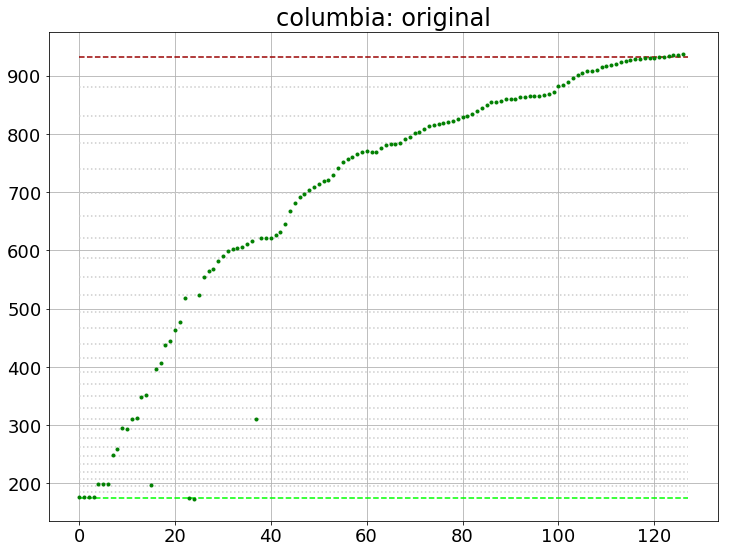

In [97]:
def plotFrequencies(pitches, name, write=False):
    pitches = np.array(pitches)
    fig = plt.figure(figsize=(12, 9), frameon=True)
    plt.title(name + ": original", fontsize=24)
    plt.hlines([F3, Bb5], xmin=0, xmax=len(pitches), linestyles="dashed", colors=["#00FF00", "#990000"])
    plt.hlines(intermediateNotes, xmin=0, xmax=len(pitches), linestyles="dotted", colors="#CCCCCC")
    ax = fig.gca()
    ax.tick_params(labelsize=18)
    ax.plot(pitches, '.g', color="green")
    plt.grid()
    plt.show()
    if write:
        image_path = "../output/images/%s_original.png" % name
        fig.savefig(image_path, pad_inches=1, dpi=300)
        
plotFrequencies(pitches, name, True)

In [108]:
corrected = [ (p, "green") for p in pitches ]

THRESHOLD = 0.2

# The notes should always be ascending, but there are inevitable errors. Let's correct that.
for i in range(1, len(corrected) - 1):
    # difference between current pitch and previous pitch
    current = corrected[i][0]
    previous = corrected[i-1][0]
    following = corrected[i+1][0]
    
    diff_trailing = (current - previous) / current # should be negative
    diff_leading = (following - current) / current # should also be positive

    # if the previous note is above the current one...
    if diff_trailing > THRESHOLD:
        # if the outlier falls between two points in the correct slope
        if diff_leading >= THRESHOLD:
            average = (following + previous) / 2
            print('raising note at %s (originaly %s) to %s, average between %s and %s (%s - %s)' % (i, current, average, previous, following, diff_trailing, diff_leading))
            corrected[i] = (average, "blue")
        # if there are two low notes ahead, bring the low one up to the precious value
        else:
            print('equating note at %s (originaly %s) to previous value %s since next value %s isn\'t higher (%s - %s)' % (i, current, previous, following, diff_trailing, diff_leading))
            corrected[i] = (previous, "blue")
            
    # else if subsequent note is below current one
    elif diff_leading < -THRESHOLD:
        # if the outlier falls between two points in the correct slope, take the average
        if diff_trailing < -THRESHOLD:            
            average = (following + previous) / 2
            print('lowering note at %s (originaly %s) to %s, between %s and %s (%s - %s)' % (i, current, average, previous, following, diff_trailing, diff_leading))
            corrected[i] = (average, "blue")
        # if there are two low notes ahead 
        else:
            print('equating note at %s (originaly %s) to subsequent value %s since next value %s isn\'t higher (%s - %s)' % (i, current, previous, following, diff_trailing, diff_leading))
            corrected[i] = (following, "blue")
            

equating note at 14 (originaly 351.20004) to subsequent value 349.03812 since next value 196.93379 isn't higher (0.0061558257 - -0.43925464)
equating note at 16 (originaly 396.1972) to previous value 196.93379 since next value 406.0547 isn't higher (0.50294 - 0.024880243)
equating note at 17 (originaly 406.0547) to previous value 196.93379 since next value 438.1527 isn't higher (0.5150067 - 0.07904852)
equating note at 18 (originaly 438.1527) to previous value 196.93379 since next value 444.222 isn't higher (0.55053616 - 0.013851962)
equating note at 19 (originaly 444.222) to previous value 196.93379 since next value 462.748 isn't higher (0.55667704 - 0.041704375)
equating note at 20 (originaly 462.748) to previous value 196.93379 since next value 477.4924 isn't higher (0.5744254 - 0.031862732)
equating note at 21 (originaly 477.4924) to previous value 196.93379 since next value 518.61334 isn't higher (0.5875666 - 0.08611853)
equating note at 22 (originaly 518.61334) to previous value 

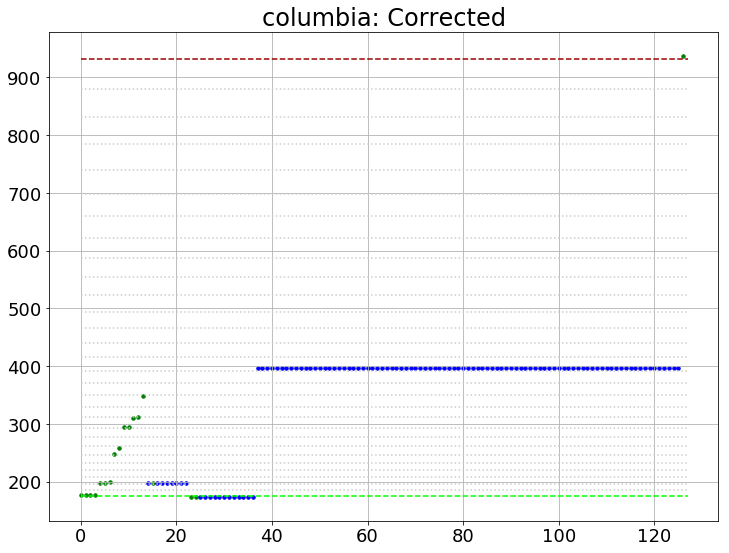

In [106]:
fig = plt.figure(figsize=(12, 9), frameon=True)
plt.title(name + ": Corrected", fontsize=24)
plt.hlines([F3, Bb5], xmin=0, xmax=len(pitches), linestyles="dashed", colors=["#00FF00", "#990000"])
plt.hlines(intermediateNotes, xmin=0, xmax=len(pitches), linestyles="dotted", colors="#CCCCCC")
ax = fig.gca()
ax.tick_params(labelsize=18)
for (i,c) in enumerate(corrected):
    ax.scatter(i,c[0], color=c[1], s=12)
plt.grid()
plt.show()

In [79]:
corrected = [ (p, "green") for p in pitches ]
# first, identify all the outliers and move them closer to the correct position
for i in range(1, len(pitches)-1):
    diff = abs(pitches[i]-corrected[i-1]) / corrected[i-1]
    if diff > 0.4:
        corrected += [corrected[i-1]]
        #print(1, i, pitches[i], corrected[i-1], diff, average)        
    elif diff > 0.25:
        average = (corrected[i-1] + pitches[i+1]) / 2
        #print(1, i, pitches[i], corrected[i-1], diff, average)
        corrected += [average]
    else:
        corrected += [pitches[i]]

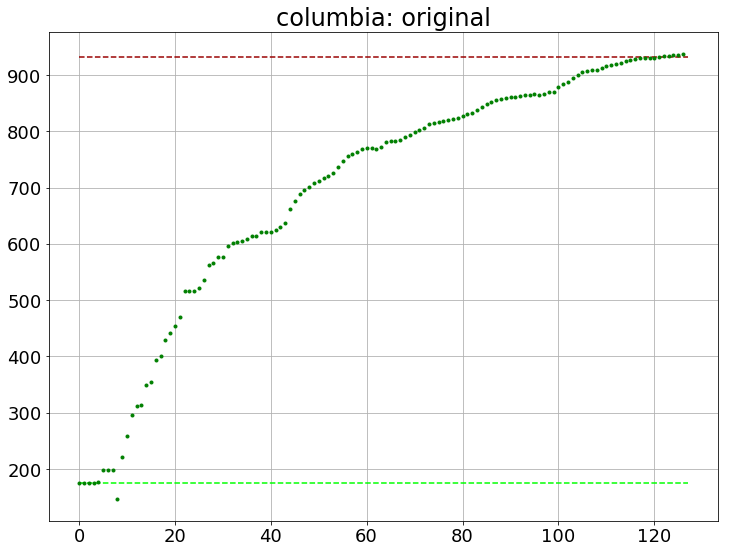

In [80]:
plotFrequencies(corrected, name)

In [81]:
# then iterate over the corrected array, gradually bringing the outliers into line
for x in range(2,20):
    arr = corrected
    for i in range(1, len(arr)-1):
        diff = abs(arr[i] - arr[i+1]) / arr[i+1]
        threshold = 1 - 0.06 * x
        if diff > threshold:
            average = (arr[i-1] + arr[i+1]) / 2
            #print(x, i, threshold, arr[i], corrected[i-1], diff, average)
            corrected[i] = average

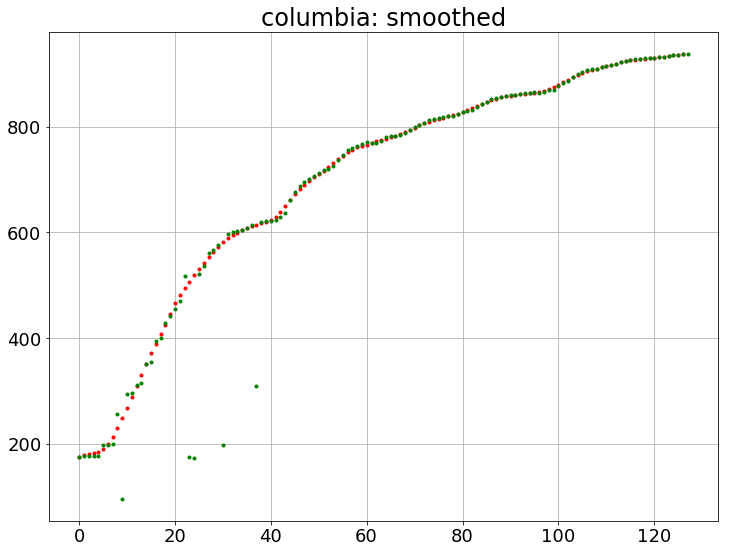

In [82]:
fig = plt.figure(figsize=(12, 9), frameon=True)
plt.title(name + ": smoothed", fontsize=24)
#ax = fig.add_axes([0,0,1,1])
ax = fig.gca()
ax.tick_params(labelsize=18)
ax.plot(corrected, '.g', color="red")
ax.plot(pitches, '.g', color="green")
plt.grid()
plt.show()

In [229]:
image_path = "../output/images/%s_smoothed.png" % name
fig.savefig(image_path, pad_inches=1, dpi=300)

In [230]:
data_path = "../output/data/%s.csv" % name

with open(data_path, "w") as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(["freq"])    
    spamwriter.writerows(map(lambda x: [x], corrected))